# Model evaluation using the Peltarion Deployment API

In this notebook you will learn how to use the Deployment API of the Peltarion platform to get predictions on  samples and evaluate the performance of the deployed model in more detail.

In [1]:
import os
import numpy as np
from PIL import Image
from matplotlib.pyplot import imshow
import pandas as pd
import requests
import base64
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline

## Configuration

Replace the __URL__ and __TOKEN__ with those of your deployed model.

Specify the path to the index file and images (__out_path__ in the Pre-processing notebook).

In [2]:
URL = 'https://a.peltarion.com/deployment/86448268-b20f-48dd-b3c5-114337ea9375/forward'

TOKEN = '79b6a504-c513-4c16-a67c-5943b202dad8'

PATH = "/home/asa/demo/out_60_45"

## Define functions for preparing data, calling API and plotting results

In [3]:
# Encode single image in base64 format for deployment API
def encode_img(path):
    img_type = os.path.splitext(path)[-1][1:]
    with open(path, "rb") as image_file:
        encoded_img = 'data:image/{};base64,'.format(img_type) + base64.b64encode(image_file.read()).decode('ascii')
    return encoded_img

# Get predictions from deployment api 
def get_predictions(data, token, url):
    headers = {
    'Content-Type': "application/json",
    'Authorization': "Bearer {}".format(token),
    }
    response = requests.request("POST", url, data=data, headers=headers)
    return response.json()

# Get binary predictions (malignant considered the positive class)
def get_binary_predictions(data, token, url):
    print("Requesting model predictions from deployment API, this might take a few minutes...")
    preds = get_predictions(data, token, url)
    binary_preds = [s["benign_malignant"]["malignant"]for s in preds["rows"]]
    print("Done!")
    return binary_preds

# Prepare input data for deployment api
def prepare_api_data(df):    
    img_files = [os.path.join(PATH, img) for img in df["image"].values]
    encoded_imgs = [encode_img(f) for f in img_files]
    input_batch = ','.join(["{\"image\":\"" + encoded_img + "\"}" for encoded_img in encoded_imgs])
    payload = "{\"rows\": [" + input_batch + "]}"
    return payload

# Get random misclassified examples, given threshold as the classification threshold
def get_incorrect_predictions(df, true_class='malignant', n_samples=5, threshold=0.5):
    if true_class == 'malignant':
        filtered = df[df['benign_malignant'] == 'malignant']
        filtered = filtered[filtered['preds'] < threshold]
    elif true_class == 'benign':
        filtered = df[df['benign_malignant'] == 'benign']
        filtered = filtered[filtered['preds'] > threshold]
    num_samples = min(n_samples, filtered.shape[0])
    filtered = filtered.sample(n=num_samples)
    return filtered  
    
# Plot distribution of predictions for actual benign and malignant class
def plot_hist(benign_preds, 
              malignant_preds):
    f, ax = plt.subplots(1, 1, figsize = (14,9))
    plt.hist(benign_preds, bins=100, alpha=0.5, label='Actual Benign',density=True)
    plt.hist(malignant_preds, bins=100, alpha=0.5, label='Actual Malignant', density=True)
    ax.set_xlabel('Predicted value', fontsize=16)
    ax.set_ylabel('Number of samples', fontsize=16)
    ax.set_title('Distribution of predicted values for Benign and Malignant samples',fontsize=20)
    plt.legend(loc='upper right', fontsize=16)
    plt.show()

# Plot ROC curve
def plot_roc_curve(df):
    y_true = (df['benign_malignant']=='malignant').values
    y_prob = df['preds']
    fpr, tpr, thresholds_roc = metrics.roc_curve(y_true=y_true, y_score=y_prob)
    auc = metrics.auc(fpr, tpr)
    
    f, ax = plt.subplots(1, 1, figsize = (9,9));
    plt.plot(fpr, tpr)
    ax.set_xlabel('False positive rate / 1 - Specificity', fontsize=16)
    ax.set_ylabel('True positive rate / Sensitivity / Recall', fontsize=16)
    ax.set_title(f'ROC curve, AUC {round(auc, ndigits=2)}', fontsize=20)
    plt.show()
    
# Print model metrics
def print_metrics(df, threshold=0.5):
    y_true = (df['benign_malignant']=='malignant').values
    y_prob = df['preds']
    fpr, tpr, thresholds_roc = metrics.roc_curve(y_true=y_true, y_score=y_prob)
    auc = metrics.auc(fpr, tpr)
    
    recall = metrics.recall_score(y_true=y_true, y_pred=y_prob>threshold)
    precision = metrics.precision_score(y_true=y_true, y_pred=y_prob>threshold)
    spec = metrics.recall_score(y_true=y_true, y_pred=y_prob>threshold, pos_label=0)
    
    print("CONFUSION MATRIX")
    print(metrics.confusion_matrix(y_pred=y_prob>0.5, y_true=y_true))
    print()
    print("AUC")
    print(auc)
    print()
    print("Recall/Sensitivity")
    print(recall)
    print()
    print("Precision")
    print(precision)
    print()
    print("Specificity")
    print(spec)

## Get predictions for the validation samples

In [4]:
df = pd.read_csv(os.path.join(PATH, "index.csv"))
df = df[df["benign_malignant"] != "unknown"]
df_val = df[df["subset"] == "val"]
print("Number of validation data samples: ", str(len(df_val)))

Number of validation data samples:  1480


In [5]:
# Get predictions from deployment api for the validation data set
payload = prepare_api_data(df_val)
binary_preds = get_binary_predictions(payload, TOKEN, URL)

# Insert predictions into dataframe
df_val["preds"] = binary_preds
df_val.head()

Requesting model predictions from deployment API, this might take a few minutes...
Done!


/home/asa/.virtualenvs/learn-pandas/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,image,age,benign_malignant,diagnosis,diagnosis_confirm_type,sex,subset,preds
17,ISIC_0024323.jpg,50.0,malignant,melanoma,histopathology,male,val,2.089981e-03
27,ISIC_0024333.jpg,85.0,malignant,melanoma,histopathology,male,val,7.333096e-01
28,ISIC_0024334.jpg,45.0,benign,nevus,serial imaging showing no change,female,val,3.745826e-12
41,ISIC_0024347.jpg,25.0,benign,nevus,serial imaging showing no change,female,val,3.580509e-03
61,ISIC_0024367.jpg,35.0,malignant,melanoma,histopathology,female,val,9.887090e-01


## ROC curve

From the ROC curve we can see what false positive rate we have to accept in order to achieve a certain true positive rate. 

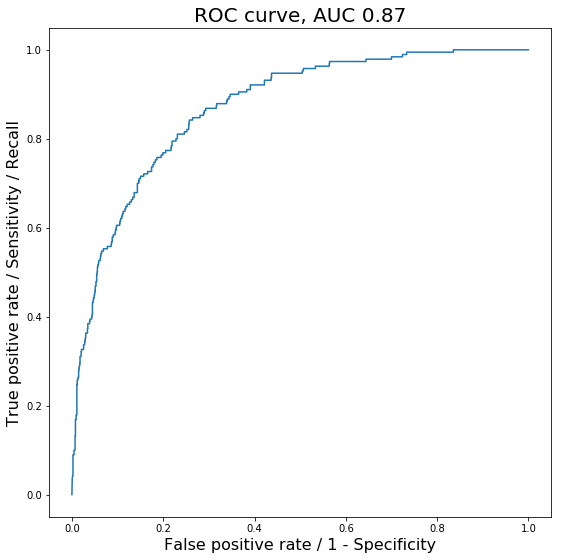

In [6]:
plot_roc_curve(df_val)

## Histogram of predictions for the actual benign vs malignant samples

Ideally there should be one blue bar close to 0, representing the "Actual Benign" samples, and one orange bar close to 1, representing the "Actual Malignant" samples. By visualizing the raw predictions like this we can get a sense of how well the model is able to separate the two classes.

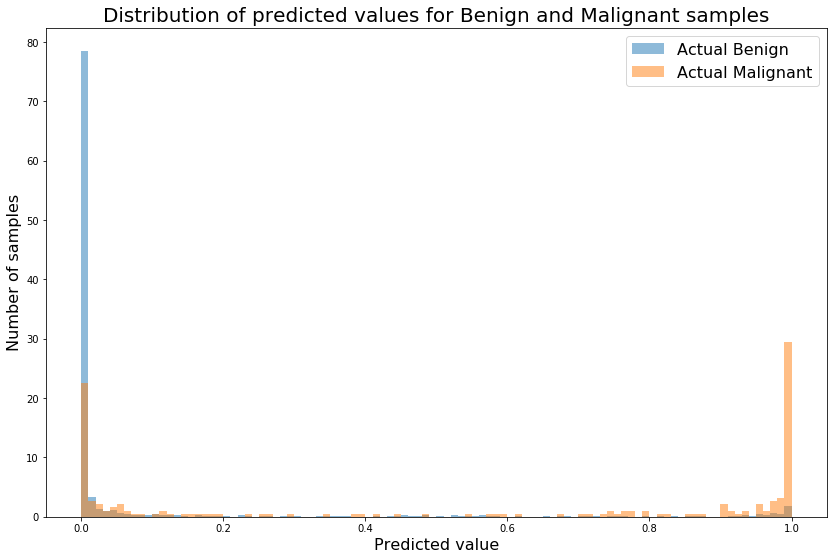

In [7]:
benign_preds = df_val[df_val['benign_malignant'] == 'benign']['preds'].values
malignant_preds = df_val[df_val['benign_malignant'] == 'malignant']['preds'].values
plot_hist(benign_preds, malignant_preds)

## Visualize the worst misclassified samples

By looking at the misclassified samples we can potentially get some ideas as to what the model is not able to capture, and use it to improve our model in the next iteration.

### Visualize false negatives (these samples are malignant but the model classifies them as benign)

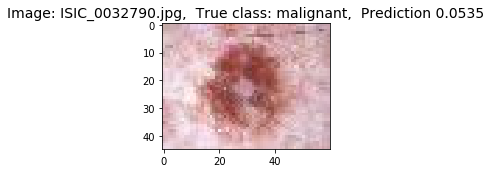

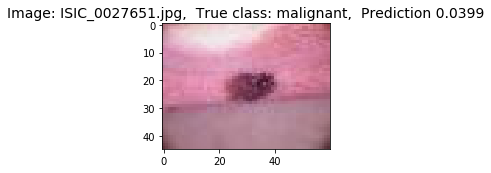

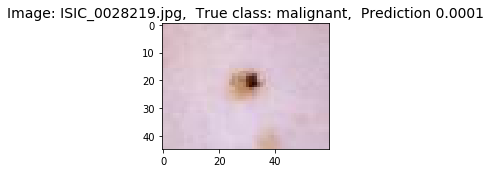

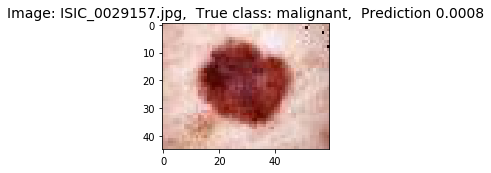

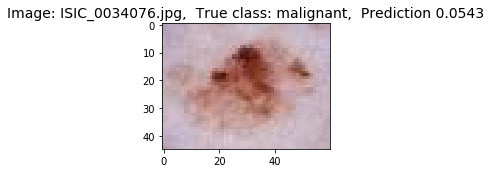

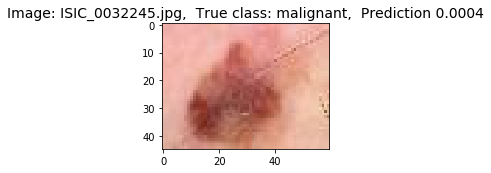

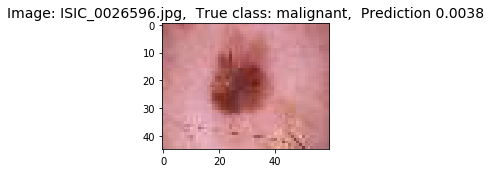

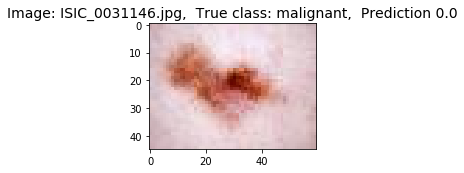

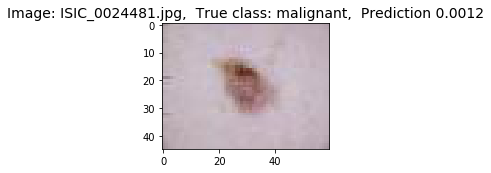

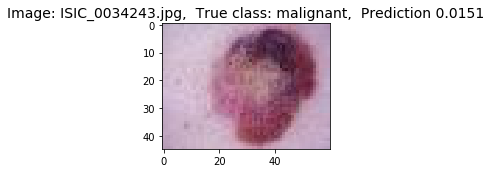

In [8]:
false_neg = get_incorrect_predictions(df_val, true_class='malignant', n_samples=10, threshold=0.1)

for idx, row in false_neg.iterrows():
    f, ax = plt.subplots(1, 1, figsize = (3,3))
    plt.imshow(np.array(Image.open(os.path.join(PATH, row["image"]))))
    ax.set_title(f"Image: {row['image']},  True class: {row['benign_malignant']},  Prediction {round(row['preds'], ndigits=4)}", fontsize=14)
    

### Visualize false positives (these samples are benign but the model classifies them as malignant )

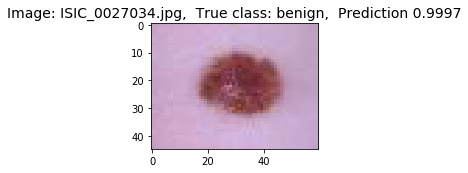

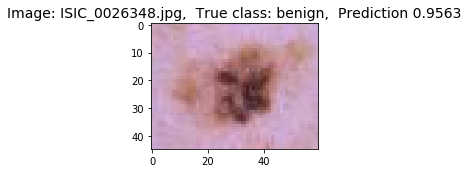

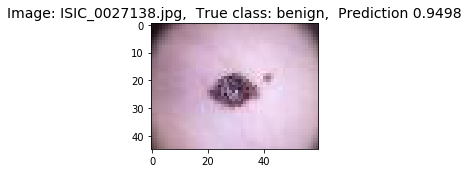

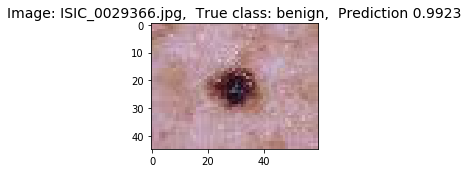

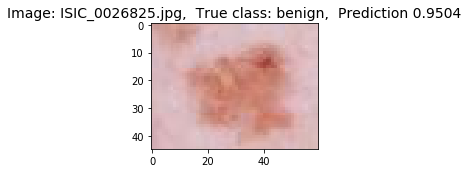

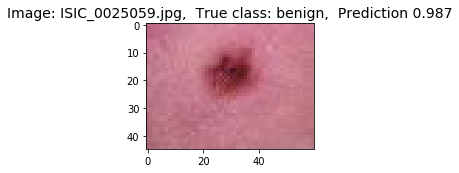

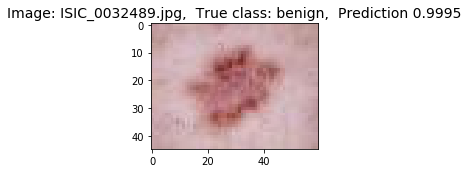

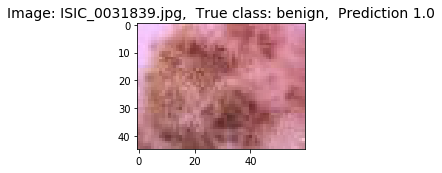

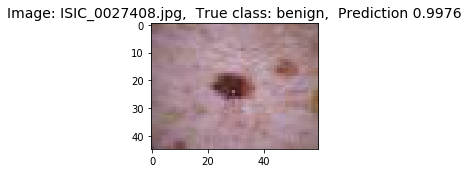

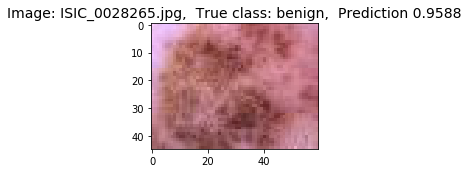

In [9]:
false_pos = get_incorrect_predictions(df_val, true_class='benign', n_samples=10, threshold=0.9)

for idx, row in false_pos.iterrows():
    f, ax = plt.subplots(1, 1, figsize = (3,3))
    plt.imshow(np.array(Image.open(os.path.join(PATH, row["image"]))))
    ax.set_title(f"Image: {row['image']},  True class: {row['benign_malignant']},  Prediction {round(row['preds'], ndigits=4)}", fontsize=14)

In [10]:
print_metrics(df_val)

CONFUSION MATRIX
[[1193   97]
 [  85  105]]

AUC
0.8704018767849858

Recall/Sensitivity
0.5526315789473685

Precision
0.5198019801980198

Specificity
0.9248062015503876
